In [1]:
import pandas as pd, numpy as np, seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc
from collections import OrderedDict
from os import path
from matplotlib.colors import Normalize, LinearSegmentedColormap, to_rgba
from matplotlib.patches import Rectangle, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

style.use(["seaborn-poster", "seaborn-whitegrid"])
rc("axes", linewidth=1, edgecolor="black")
%matplotlib inline

In [2]:
def load_SARTools(compid):
    for tp in "postvspre", "spacevspre", "postvsspace":
        fn = f"SARTools/all_genes/{compid}/{tp}.complete.txt.xz"
        if path.exists(fn):
            df = pd.read_csv(fn, sep="\t", index_col=0)
            break
    else:
        raise OSError
    if tp == "postvsspace":
        df["log2FoldChange"] = -df["log2FoldChange"]
    def _SARTools_gencolnames():
        for cc in map(lambda c: c.lstrip("."), df.columns):
            if cc.startswith("C00"):
                L1 = "featureCounts"
                L2, L3 = cc.split(".", 1)
            elif cc.startswith("norm.C00"):
                L1 = "normCounts"
                _, L2, L3 = cc.split(".", 2)
            elif cc.startswith("norm..C00"):
                L1 = "normCounts"
                *_, L2, L3 = cc.split(".", 3)
            elif cc == "log2FoldChange":
                L1, L2, L3 = "inference", "DESeq2", "log2FC"
            else:
                L1, L2, L3 = "inference", "DESeq2", cc
            if L3 == "2021.09.2":
                L3 = "2021.09.2post"
            yield (L1, L2, L3)
    df.columns = pd.MultiIndex.from_tuples(_SARTools_gencolnames())
    df.index.name = "name"
    return df

PIPETRANSDE_CONVCOLS = {
    "PRE1_sum": ("C001", "2021.06"), "PRE2_sum": ("C002", "2021.06"), "PRE3_sum": ("C003", "2021.06"),
    "PRE4_sum": ("C004", "2021.06"), "PRE5_sum": ("C001", "2021.08"), "PRE6_sum": ("C002", "2021.08"),
    "PRE7_sum": ("C003", "2021.08"), "PRE8_sum": ("C004", "2021.08"), "PRE9_sum": ("C001", "2021.09.1pre"),
    "PRE10_sum": ("C002", "2021.09.1pre"), "PRE11_sum": ("C003", "2021.09.1pre"),
    "PRE12_sum": ("C004", "2021.09.1pre"), "POST1_sum": ("C001", "2021.09.2post"),
    "POST2_sum": ("C002", "2021.09.2post"), "POST3_sum": ("C003", "2021.09.2post"),
    "POST4_sum": ("C004", "2021.09.2post"), "POST5_sum": ("C001", "2021.11"),
    "POST6_sum": ("C002", "2021.11"), "POST7_sum": ("C003", "2021.11"), "POST8_sum": ("C004", "2021.11"),
    "POST9_sum": ("C001", "2021.12"), "POST10_sum": ("C002", "2021.12"), "POST11_sum": ("C003", "2021.12"),
    "POST12_sum": ("C004", "2021.12"), "POST13_sum": ("C001", "2022.03"), "POST14_sum": ("C002", "2022.03"),
    "POST15_sum": ("C003", "2022.03"), "POST16_sum": ("C004", "2022.03"),
}

def load_pipetransde(compid):
    df = pd.concat(
        axis=1, objs=[
            pd.read_csv(f"pipeline-transcriptome-de/{compid}/merged/all_gene_counts.tsv.xz", sep="\t"),
            pd.read_csv(f"pipeline-transcriptome-de/{compid}/de_analysis/results_dge.tsv.xz", sep="\t")
        ],
    )
    def _pipetransde_getcolnames():
        for cc in df.columns:
            if cc in PIPETRANSDE_CONVCOLS:
                yield ("pipeline-transcriptome-de.counts", *PIPETRANSDE_CONVCOLS[cc])
            elif cc == "logFC":
                yield ("inference", "pipeline-transcriptome-de", "log2FC")
            else:
                yield ("inference", "pipeline-transcriptome-de", cc)
    df.index.name = "name"
    df.columns = pd.MultiIndex.from_tuples(_pipetransde_getcolnames())
    return df

def load_and_merge(compid):
    df = pd.concat([load_SARTools(compid), load_pipetransde(compid)], axis=1)
    df = df[sorted(df.columns)].copy()
    df = df[["featureCounts", "normCounts", "pipeline-transcriptome-de.counts", "inference"]]
    for col in "featureCounts", "normCounts", "pipeline-transcriptome-de.counts":
        df[col] = df[col].fillna(0).astype(int)
    return df

In [3]:
postVpre1 = load_and_merge("postVpre1")
postVpre2 = load_and_merge("postVpre2")
postVpre3 = load_and_merge("postVpre3")

recVpre1 = load_and_merge("recVpre1")
recVpre2 = load_and_merge("recVpre2")
recVpre3 = load_and_merge("recVpre3")
recVpre4 = load_and_merge("recVpre4")
recVpre5 = load_and_merge("recVpre5")

postVrec1 = load_and_merge("postVrec1")
postVrec2 = load_and_merge("postVrec2")
postVrec3 = load_and_merge("postVrec3")
postVrec4 = load_and_merge("postVrec4")
postVrec5 = load_and_merge("postVrec5")

dfs = [
    postVpre1, postVpre2, postVpre3,
    recVpre1, recVpre2, recVpre3, recVpre4, recVpre5,
    postVrec1, postVrec2, postVrec3, postVrec4, postVrec5,
]

dfnames2profiles = OrderedDict([
    ("postVpre1", "I4-FP1"),
    ("postVpre2", "I4-FP2"),
    ("postVpre3", "I4-FP3"),
    ("recVpre1",  "I4-LP1"),
    ("recVpre2",  "I4-LP2"),
    ("recVpre3",  "I4-LP4"),
    ("recVpre4",  "I4-LP5"),
    ("recVpre5",  "I4-LP6"),
    ("postVrec1", "I4-RP1"),
    ("postVrec2", "I4-RP2"),
    ("postVrec3", "I4-RP4"),
    ("postVrec4", "I4-RP5"),
    ("postVrec5", "I4-RP6"),
])

dfnames = list(dfnames2profiles)

FC_BREAKPOINT = 8
DISP = ["L-92", "L-44", "L-3", "R+1", "R+45", "R+82", "R+194"]
DISC = ["#68BBDA", "#377EB8", "#3E4D8A", "#E41A1C", "#D9742C", "#ECB03B", "#825F1D"]

In [4]:
def zlog(df, vizgenes, normlib=True, divstd=True, pseudo=.01):
    if normlib:
        t = df.div(df.mean(axis=0))
    else:
        t = df.copy()
    t = np.log10(t + pseudo)
    if divstd:
        t = t.sub(t.mean(axis=1), axis=0).div(t.std(axis=1), axis=0).reindex(vizgenes)
    else:
        t = t.sub(t.mean(axis=1), axis=0).reindex(vizgenes)
    return t[sorted(t.columns, key=lambda x:x[1])].copy()

In [5]:
vizgenes = set.union(*(
    set(df[
        (df[("inference", "DESeq2", "padj")]<.05) & (df[("inference", "pipeline-transcriptome-de", "FDR")]<.05)
    ].index)
    for df in dfs
))

viz_fcz = zlog(postVpre3["featureCounts"], vizgenes)
viz_ptz = zlog(postVpre3["pipeline-transcriptome-de.counts"], vizgenes)
viz_avz = zlog(.5 * (postVpre3["featureCounts"] + postVpre3["pipeline-transcriptome-de.counts"]), vizgenes)

In [6]:
SUP, SDN = "↑", "↓"
SUP, SDN = "▴", "▾"

def mktins(df, dfname, vizgenes):
    tin = df.reindex(vizgenes)["inference"].copy()
    tin[("DESeq2", "log2FC")] = tin[("DESeq2", "log2FC")].fillna(0)
    tin[("pipeline-transcriptome-de", "log2FC")] = tin[("pipeline-transcriptome-de", "log2FC")].fillna(0)
    tin[("combined", "significant")] = False
    tin.loc[
        (((tin[("DESeq2", "log2FC")]>0) & (tin[("pipeline-transcriptome-de", "log2FC")]>0) |
          (tin[("DESeq2", "log2FC")]<0) & (tin[("pipeline-transcriptome-de", "log2FC")]<0)) &
         ((tin[("DESeq2", "padj")]<.05) & (tin[("pipeline-transcriptome-de", "FDR")]<.05))
        ),
        ("combined", "significant")
    ] = True
    tin[("combined", "direction")] = " "
    tin.loc[(tin[("combined", "significant")]==True) & (tin[("DESeq2", "log2FC")]<0), ("combined", "direction")] = SDN
    tin.loc[(tin[("combined", "significant")]==True) & (tin[("DESeq2", "log2FC")]>0), ("combined", "direction")] = SUP
    _deseq = tin[("DESeq2", "log2FC")].rename(dfname).copy()
    _ptd = tin[("pipeline-transcriptome-de", "log2FC")].rename(dfname).copy()
    return _deseq, _ptd, tin[("combined", "direction")].rename(dfname).copy()

In [7]:
DESeq2_log2FCs, ptd_log2FCs, directions = [], [], []

for df, dfname in zip(dfs, dfnames):
    _d, _p, _t = mktins(df, dfname, vizgenes)
    DESeq2_log2FCs.append(_d)
    ptd_log2FCs.append(_p)
    directions.append(_t)

def _merge_tins(tins):
    log2FC = pd.concat(tins, axis=1)
    _min = min([x for x in log2FC.values.flatten() if (x != float("-inf")) and (not pd.isnull(x))])
    _max = max([x for x in log2FC.values.flatten() if (x != float("inf")) and (not pd.isnull(x))])
    return (
        log2FC
        .applymap(lambda x: _min if x == float("-inf") else x)
        .applymap(lambda x: _max if x == float("inf") else x)
    )

DESeq2_log2FC = _merge_tins(DESeq2_log2FCs)
ptd_log2FC = _merge_tins(ptd_log2FCs)
direction = pd.concat(directions, axis=1)

target_genes = set.intersection(
    set(DESeq2_log2FC[(~DESeq2_log2FC.isnull()).any(axis=1)].index),
    set(ptd_log2FC[(~ptd_log2FC.isnull()).any(axis=1)].index)
)

In [8]:
def squishax(ax, factor=2, scalef=None):
    x0, y0, x1, y1 = ax.get_position().bounds
    adjust = (x1 - x0) * (factor-1) / factor
    ax.set_position([x0+adjust, y0, x1-adjust, y1])
    if scalef:
        ax.set_xscale("function", functions=(scalef, lambda _:_))

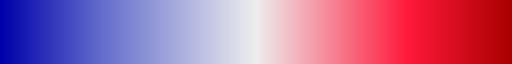

In [9]:
CntCmap = LinearSegmentedColormap.from_list(
    "CntCmap", ((.0, "#0000AA"), (.2, "#646ECD"), (.5, "#EEEEEE"), (.8, "#FF183A"), (1., "#AA0000")),
)
CntCmap

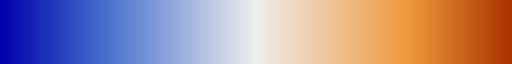

In [10]:
DegCmap = LinearSegmentedColormap.from_list(
    "DegCmap", ((.0, "#0000AA"), (.2, "#446ECD"), (.5, "#EEEEEE"), (.8, "#EE983A"), (1., "#AA3300")),
)
DegCmap

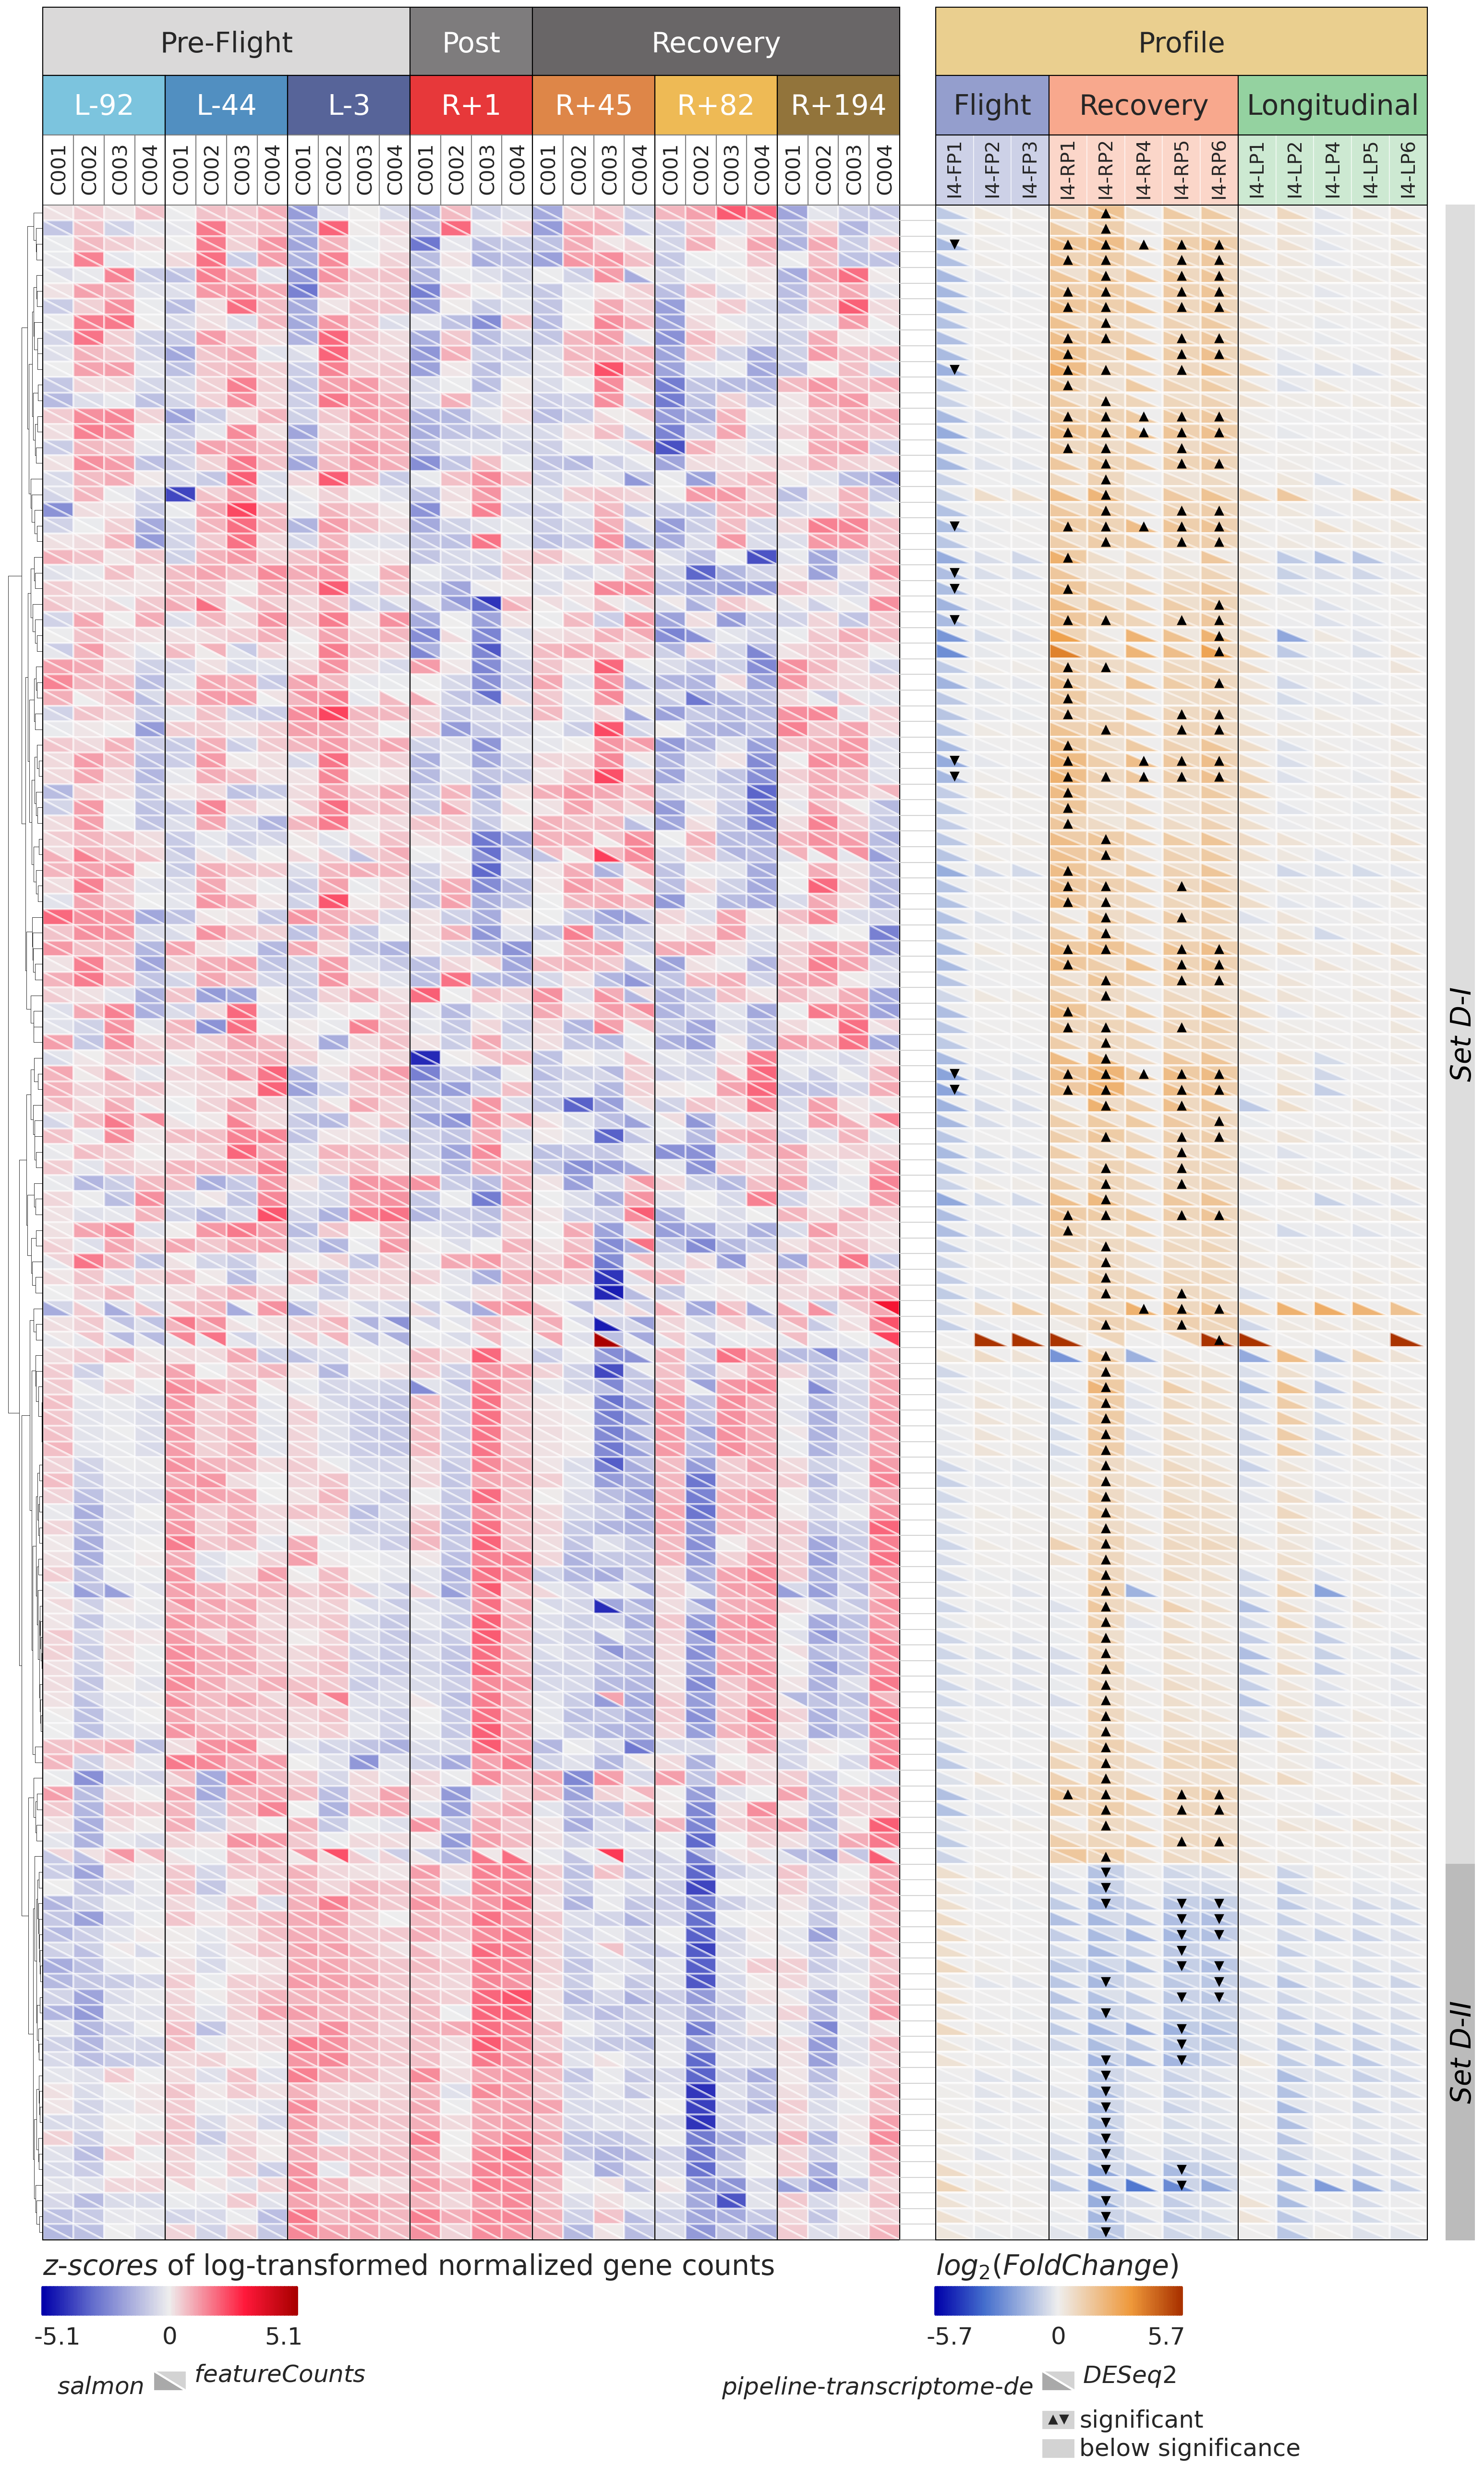

In [11]:
FHUG, FBIG, FMED, FSML = 28, 24, 20, 18
yfactor = 1.9
T1 = -6.65 * yfactor
H1 = 2.3 * yfactor
M1 = -5.4 * yfactor
T3 = -2.35 * yfactor
H3 = 2.35 * yfactor
M3 = -1.23 * yfactor
T2 = -4.35 * yfactor
H2 = 2 * yfactor
M2 = -3.3 * yfactor

# cluster backbone (viz_avz), set up colormap (CntCmap):
vmax = max(viz_fcz.abs().max().max(), viz_ptz.abs().max().max())
scm = ScalarMappable(cmap=CntCmap, norm=Normalize(vmin=-vmax, vmax=vmax))
g = sns.clustermap(
    data=viz_avz, metric="correlation", method="ward", col_cluster=False,
    cmap=CntCmap, vmin=-vmax, vmax=vmax, lw=0,
    cbar_pos=None, dendrogram_ratio=.025, figsize=(23, 32),
)
squishax(g.ax_row_dendrogram, 1, lambda x: x**.5)

# paint over backbone with values of viz_fcz and viz_ptz:
for y, gene in enumerate(g.data2d.index):
    for x, column in enumerate(g.data2d.columns):
        g.ax_heatmap.add_patch(Polygon( # upper right: featureCounts
            [[x, y], [x+1, y], [x+1, y+1]], closed=True, ec="#FFFFFF88", lw=2,
            fc=scm.to_rgba(viz_fcz.loc[gene, column]),
        ))
        g.ax_heatmap.add_patch(Polygon( # lower left: salmon
            [[x, y], [x, y+1], [x+1, y+1]], closed=True, ec="#FFFFFF88", lw=2,
            fc=scm.to_rgba(viz_ptz.loc[gene, column]),
        ))

# annotate counts/subjects sections:
hax = g.ax_heatmap
hax.set(xticks=[], xlabel=None)
hax.add_patch(Rectangle((0, T1), 12, H1, fc="#DAD9D9", ec="black", lw=1, clip_on=False))
hax.add_patch(Rectangle((12, T1), 4, H1, fc="#7E7C7D", ec="black", lw=1, clip_on=False))
hax.add_patch(Rectangle((16, T1), 12, H1, fc="#696667", ec="black", lw=1, clip_on=False))
hax.text(s="Pre-Flight", x=6, y=M1, ha="center", va="center", size=FHUG)
hax.text(s="Post", x=14, y=M1, ha="center", va="center", size=FHUG, color="w")
hax.text(s="Recovery", x=22, y=M1, ha="center", va="center", size=FHUG, color="w")
for i, kind in enumerate(["pre"]*3+["space"]+["rec"]*3):
    hax.add_patch(Rectangle((i*4, 0), 4, len(viz_fcz), fc="none", ec="black", lw=1, clip_on=False))
    hax.add_patch(Rectangle((i*4, T2), 4, H2, fc=DISC[i]+"DD", ec="black", lw=1, clip_on=False))
    hax.text(s=DISP[i], x=i*4+2, y=M2, color="white", ha="center", va="center", size=FHUG)
    for j in range(4):
        hax.add_patch(Rectangle((i*4+j, T3), 1, H3, fc="none", ec="gray", lw=1, clip_on=False))
        hax.text(s=f"C00{j+1}", x=i*4+j+.55, y=M3, ha="center", va="center", rotation=90, size=FMED)
    hax.add_patch(Rectangle((i*4, T2), 4, -T2+hax.get_ylim()[0], fc="none", ec="black", lw=1, clip_on=False))

# annotate underneath counts: custom colorbar
hax.text(
    s="$z$-$scores$ of log-transformed normalized gene counts", ha="left", va="bottom",
    x=0, y=hax.get_ylim()[0]+1.4*yfactor, size=FHUG,
)
for x, c in zip(np.linspace(0, 8.3, 200), np.linspace(-vmax, vmax, 200)):
    hax.plot(
        [x, x], [hax.get_ylim()[0]+1.6*yfactor, hax.get_ylim()[0]+2.5*yfactor],
        color=scm.to_rgba(c), clip_on=False,
    )
hax.text(s=f"{-vmax:.1f}", x=-.3, y=hax.get_ylim()[0]+2.9*yfactor, ha="left", va="top", size=FBIG)
hax.text(s="0", x=4.15, y=hax.get_ylim()[0]+2.9*yfactor, ha="center", va="top", size=FBIG)
hax.text(s=f"{vmax:.1f}", x=8.5, y=hax.get_ylim()[0]+2.9*yfactor, ha="right", va="top", size=FBIG)

# annotate underneath counts: explain triangles
xofs, yofs = 3.7, hax.get_ylim()[0] + 4.4*yfactor
widen = .1
hax.add_patch(Polygon(
    [[xofs-widen, yofs+0], [xofs-widen, yofs+1.3], [xofs+.9+widen, yofs+1.3]],
    fc="darkgray", ec="white", lw=2, clip_on=False,
))
hax.add_patch(Polygon(
    [[xofs-widen, yofs+0], [xofs+.9+widen, yofs+0], [xofs+.9+widen, yofs+1.3]],
    fc="lightgray", ec="white", lw=2, clip_on=False,
))
hax.text(s="$salmon$  ", ha="right", va="top", x=xofs-widen, y=yofs+.3, size=FBIG)
hax.text(s=" $featureCounts$", ha="left", va="bottom", x=xofs+.9+widen, y=yofs+1, size=FBIG)

# extend lines between gene names:
hax.set(yticks=[], ylabel=None)
for y in range(1, len(g.data2d)):
    hax.plot([28, 30], [y, y], clip_on=False, lw=1, color="lightgray")
hax.plot([28, 30], [0, 0], clip_on=False, lw=1, color="gray")
hax.plot([28, 30], [len(g.data2d)]*2, clip_on=False, lw=1, color="gray")

# rearrange log2FC dataframes to align with clustermap; reverse log2FCs and directions for recVpost comparisons:
fx_ptd_log2FC = ptd_log2FC.reindex(g.data2d.index).copy()
fx_ptd_log2FC.iloc[:,FC_BREAKPOINT:] = -fx_ptd_log2FC.iloc[:,FC_BREAKPOINT:]
fx_DESeq2_log2FC = DESeq2_log2FC.reindex(g.data2d.index).copy()
fx_DESeq2_log2FC.iloc[:,FC_BREAKPOINT:] = -fx_DESeq2_log2FC.iloc[:,FC_BREAKPOINT:]
fx_direction = direction.reindex(g.data2d.index).copy()
fx_direction.iloc[:,FC_BREAKPOINT:] = fx_direction.iloc[:,FC_BREAKPOINT:].applymap(lambda a:{SUP:SDN,SDN:SUP}.get(a,""))

# WATCH OUT: switch positions of longitudinal and recovery
fx_ptd_log2FC = fx_ptd_log2FC.iloc[:,[0,1,2,8,9,10,11,12,3,4,5,6,7]]
fx_DESeq2_log2FC = fx_DESeq2_log2FC.iloc[:,[0,1,2,8,9,10,11,12,3,4,5,6,7]]
fx_direction = fx_direction.iloc[:,[0,1,2,8,9,10,11,12,3,4,5,6,7]]

# add comparisons axis and plot log2FC heatmaps:
compax = make_axes_locatable(hax).append_axes("right", DESeq2_log2FC.shape[1]*.525, pad=.5)
vmax = sum([DESeq2_log2FC.abs().max().max(), ptd_log2FC.abs().max().max()]) / 2
sns.heatmap( # lower left by design: pipeline-transcriptome-de
    data=fx_ptd_log2FC.iloc[:,:], cmap=DegCmap, vmin=-vmax, vmax=vmax, cbar=False, lw=2, linecolor="#FFFFFF88",
    annot=fx_direction.iloc[:,:], fmt="s", annot_kws=dict(size=FMED, color="black", va="center"),
    ax=compax,
)
compax.set(xticks=[], yticks=[], xlabel=None, ylabel=None)
scm = ScalarMappable(cmap=DegCmap, norm=Normalize(vmin=-vmax, vmax=vmax))
for y, gene in enumerate(g.data2d.index):
    for x, column in enumerate(fx_ptd_log2FC.columns):
        compax.add_patch(Polygon( # upper right: SARTools
            [[x, y], [x+1, y], [x+1, y+1]], closed=True, ec="#FFFFFF88", lw=2,
            fc=scm.to_rgba(fx_DESeq2_log2FC.loc[gene, column]),
        ))

# annotate comparison names and groups:
for i, dfname in enumerate(fx_direction.columns):
    if i < 3:
        fc = "#949ECD"
    elif i < 8:
        fc = "#F8A88D"
    else:
        fc = "#94D2A0"
    compax.add_patch(Rectangle((i, T3), 1, H3, fc=fc+"77", ec="#FFFFFF88", lw=1, clip_on=False))
    compax.text(s=dfnames2profiles[dfname], x=i+.5, y=M3-.02, size=FMED-1, rotation=90, ha="center", va="center")
compax.add_patch(Rectangle((0, T3), fx_ptd_log2FC.shape[1], -T3, fc="none", ec="black", lw=1, clip_on=False))
compax.add_patch(Rectangle(
    (0, T3), fx_ptd_log2FC.iloc[:,:3].shape[1], -T3+fx_ptd_log2FC.shape[0],
    fc="none", ec="black", lw=1, clip_on=False,
))
compax.add_patch(Rectangle(
    (3, T3), fx_ptd_log2FC.iloc[:,3:FC_BREAKPOINT].shape[1], -T3+fx_ptd_log2FC.shape[0],
    fc="none", ec="black", lw=1, clip_on=False,
))
compax.add_patch(Rectangle(
    (FC_BREAKPOINT, T3), fx_ptd_log2FC.iloc[:,FC_BREAKPOINT:].shape[1], -T3+fx_ptd_log2FC.shape[0],
    fc="none", ec="black", lw=1, clip_on=False,
))

compax.add_patch(Rectangle((0, T2), 3, T3-T2, fc="#949ECD", ec="black", lw=1, clip_on=False))
compax.text(s="Flight", x=1.5, y=M2, size=FHUG, ha="center", va="center")
compax.add_patch(Rectangle((3, T2), 5, T3-T2, fc="#F8A88D", ec="black", lw=1, clip_on=False))
compax.text(s="Recovery", x=5.5, y=M2, size=FHUG, ha="center", va="center")
compax.add_patch(Rectangle((8, T2), 5, T3-T2, fc="#94D2A0", ec="black", lw=1, clip_on=False))
compax.text(s="Longitudinal", x=10.5, y=M2, size=FHUG, ha="center", va="center")
compax.add_patch(Rectangle((0, T1), 13, H1, fc="#EACF8F", ec="black", lw=1, clip_on=False))
compax.text(s="Profile", x=6.5, y=M1, size=FHUG, ha="center", va="center")

# annotate underneath comparison heatmap: custom colorbar
compax.text(s="$log_{2}(FoldChange)$", x=0, y=compax.get_ylim()[0]+1.4*yfactor, ha="left", va="bottom", size=FHUG)
for x, c in zip(np.linspace(0, 6.5, 200), np.linspace(-vmax, vmax, 200)):
    compax.plot([x, x], [compax.get_ylim()[0]+1.6*yfactor, compax.get_ylim()[0]+2.5*yfactor], color=scm.to_rgba(c), clip_on=False)
compax.text(s=f"{-vmax:.1f}", x=-.25, y=compax.get_ylim()[0]+2.9*yfactor, ha="left", va="top", size=FBIG)
compax.text(s="0", x=3.25, y=compax.get_ylim()[0]+2.9*yfactor, ha="center", va="top", size=FBIG)
compax.text(s=f"{vmax:.1f}", x=6.6, y=compax.get_ylim()[0]+2.9*yfactor, ha="right", va="top", size=FBIG)
compax.set(xticks=[], yticks=[], xlabel=None, ylabel=None)

# annotate underneath comparison heatmap: explain triangles
xofs, yofs = 2.8, compax.get_ylim()[0] + 4.4*yfactor
compax.add_patch(Polygon(
    [[xofs+0, yofs+0], [xofs+0, yofs+1.3], [xofs+.9, yofs+1.3]], fc="darkgray", ec="white", lw=2, clip_on=False,
))
compax.add_patch(Polygon(
    [[xofs+0, yofs+0], [xofs+.9, yofs+0], [xofs+.9, yofs+1.3]], fc="lightgray", ec="white", lw=2, clip_on=False,
))
compax.text(s="$pipeline$-$transcriptome$-$de$  ", ha="right", va="top", x=xofs, y=yofs+.3, size=FBIG)
compax.text(s=" $DESeq2$", ha="left", va="bottom", x=xofs+.9, y=yofs+1.15, size=FBIG)

yofs -= .5
compax.add_patch(Rectangle((xofs+0, yofs+3), .9, 1.3, fc="lightgray", ec="white", lw=2, clip_on=False))
compax.text(s=SUP, ha="center", va="center", x=xofs+.3, y=yofs+3.6, size=FMED)
compax.text(s=SDN, ha="center", va="center", x=xofs+.6, y=yofs+3.6, size=FMED)
compax.text(s="significant", ha="left", va="center", x=xofs+1, y=yofs+3.7, size=FBIG)

yofs += .32
compax.add_patch(Rectangle((xofs+0, yofs+4.5), .9, 1.3, fc="lightgray", ec="white", lw=2, clip_on=False))
compax.text(s="below significance", ha="left", va="center", x=xofs+1, y=yofs+5.2, size=FBIG)

# annotate gene sets:
genesettextkw = dict(rotation=90, ha="center", va="center", color="black", size=FHUG)
compax.add_patch(Rectangle((13.5, 0), .75, 106, fc="#DDD", ec="#DDD", lw=1, clip_on=False))
compax.text(s="$Set$ $D$-$I$", x=13.95, y=(0+106)/2, **genesettextkw)
compax.add_patch(Rectangle((13.5, 106), .75, 130-106, fc="#BBB", ec="#BBB", lw=1, clip_on=False))
compax.text(s="$Set$ $D$-$II$", x=13.95, y=(106+130)/2, **genesettextkw)

g.fig.dpi = 150

In [12]:
for ext in "pdf", "png":
    g.fig.savefig(f"Figure-3b.{ext}", bbox_inches="tight", dpi=300)